# CarNet

Welcome to the final assignment in this course. It's been a long journey, but you are now ready to unleash the powers of neural networks at any task. In this assignment, we will be working with a collection of photos related to driving vehicles.

In [2]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
    
# tf.config.experimental.set_visible_devices([], 'GPU')
# tf.debugging.set_log_device_placement(True)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-10-30 22:11:58.251481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 22:11:58.305561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 22:11:58.306445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%config InlineBackend.figure_format = 'retina'

# Download Data

The dataset consists of 2 segments: 
* train: the metadata file contains the file names and the count of different objects in each image.
* score: the metadata file contains the file names of images to be used for the final predictions.

Target variables (in this order):
1. signal
2. vehicle

These target variables are defined as follows:
* signal =  traffic light + stop sign
* vehicle = car + bus + truck + train + motorcycle + bicycle + airplane + boat

In [4]:
!aws s3 cp s3://danylo-ucla/carnet_dataset.zip ./
!unzip -u -q carnet_dataset.zip

download: s3://danylo-ucla/carnet_dataset.zip to ./carnet_dataset.zip


In [5]:
train_metadata = pd.read_csv('carnet_dataset/train/metadata.csv')
train_metadata.head()

,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal,file_name
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,000000000064.jpg
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000000073.jpg
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000074.jpg
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,000000000081.jpg
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000000086.jpg


In [6]:
# Score metadata defines the expected order of the photos in the submitted predictions file.

score_metadata = pd.read_csv('carnet_dataset/score/metadata.csv')
score_metadata.head()

,file_name
0,000000000071.jpg
1,000000000149.jpg
2,000000000260.jpg
3,000000000307.jpg
4,000000000690.jpg


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [8]:
train_X = load_images('carnet_dataset/train/images')
score_X = load_images('carnet_dataset/score/images')
train_Y = train_metadata.iloc[:,0:10].values

In [9]:
train_Y[0]

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

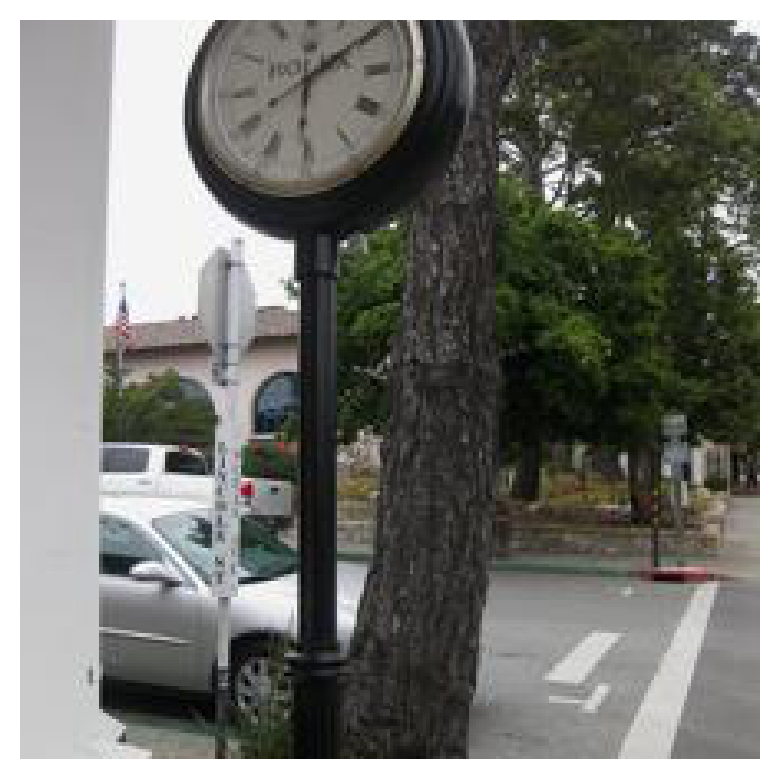

In [10]:
plt.imshow(train_X[0])
plt.axis('off')
train_Y[0]

In [11]:
train_X.shape, score_X.shape, train_Y.shape, train_metadata.shape

((23228, 224, 224, 3), (5766, 224, 224, 3), (23228, 10), (23228, 13))

In [12]:
#train and val split
from sklearn.model_selection import train_test_split
train_x, val_x, train_y,val_y, metadata_train, metadata_val= train_test_split(train_X, train_Y, train_metadata,test_size=0.1, random_state=11)

In [13]:
val_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [2., 1., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [14]:
metadata_val

,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal,file_name
7078,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000177618.jpg
16155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,000000401963.jpg
265,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,000000006819.jpg
10986,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000275744.jpg
11213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,000000281330.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,4.0,000000546226.jpg
10144,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,000000255013.jpg
21185,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,000000530197.jpg
15819,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,000000394535.jpg


# Build First Model

In [15]:
import tensorflow as tf

In [17]:
#MobilenetV3
base_model = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet")

In [18]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
base_model.trainable = False

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal', seed=11),
    tf.keras.layers.RandomRotation(0.2, seed=11),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2, seed=11),
    tf.keras.layers.Dense(10, activation='relu')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                        

In [21]:
model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss='mean_squared_error'
    )

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
history = model.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size =128,
    validation_data=(val_x, val_y),
    callbacks=[
        tf.keras.callbacks.TerminateOnNaN(),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',   
            min_delta=0.1,
            patience=3,
            cooldown=10,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',   
            min_delta=0.1,
            patience=5
        )
    ]
)

Epoch 1/10


2022-10-30 22:13:17.235294: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-10-30 22:13:17.880878: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


164/164 [==============================] - 30s 147ms/step - loss: 1.5264 - val_loss: 1.2483 - lr: 1.0000e-04
Epoch 2/10
164/164 [==============================] - 22s 134ms/step - loss: 1.3347 - val_loss: 1.1932 - lr: 1.0000e-04
Epoch 3/10
164/164 [==============================] - 22s 134ms/step - loss: 1.2837 - val_loss: 1.1744 - lr: 1.0000e-04
Epoch 4/10
163/164 [============================>.] - ETA: 0s - loss: 1.2449
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
164/164 [==============================] - 22s 134ms/step - loss: 1.2440 - val_loss: 1.1681 - lr: 1.0000e-04
Epoch 5/10
164/164 [==============================] - 22s 134ms/step - loss: 1.1909 - val_loss: 1.1475 - lr: 1.0000e-05
Epoch 6/10
164/164 [==============================] - 22s 134ms/step - loss: 1.1825 - val_loss: 1.1401 - lr: 1.0000e-05
Epoch 7/10
164/164 [==============================] - 22s 135ms/step - loss: 1.1714 - val_loss: 1.1401 - lr: 1.0000e-05
Epoch 8/10
164/164 [=========

In [23]:
#fine tuning
base_model.trainable = True

In [24]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    #optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss='mean_squared_error',
    )

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [26]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_x,
                         train_y,
                         epochs=total_epochs,
                         initial_epoch=10,
                         batch_size =128,
                         validation_data=(val_x, val_y),
                        callbacks=[
        tf.keras.callbacks.TerminateOnNaN(),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',   
            min_delta=0.1,
            patience=3,
            cooldown=10,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',   
            min_delta=0.1,
            patience=5
        )
    ])

Epoch 11/20
164/164 [==============================] - 46s 231ms/step - loss: 1.2507 - val_loss: 1.2930 - lr: 1.0000e-04
Epoch 12/20
164/164 [==============================] - 36s 221ms/step - loss: 1.1352 - val_loss: 1.1873 - lr: 1.0000e-04
Epoch 13/20
164/164 [==============================] - 36s 222ms/step - loss: 1.0810 - val_loss: 1.2232 - lr: 1.0000e-04
Epoch 14/20
164/164 [==============================] - 36s 221ms/step - loss: 1.0307 - val_loss: 1.2878 - lr: 1.0000e-04
Epoch 15/20
164/164 [==============================] - ETA: 0s - loss: 0.9931
Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
164/164 [==============================] - 36s 221ms/step - loss: 0.9931 - val_loss: 1.0964 - lr: 1.0000e-04
Epoch 16/20
164/164 [==============================] - 36s 222ms/step - loss: 0.9149 - val_loss: 1.0874 - lr: 1.0000e-05
Epoch 17/20
164/164 [==============================] - 36s 222ms/step - loss: 0.9106 - val_loss: 1.0573 - lr: 1.0000e-05
Epoch 18/2

In [27]:
val_y_multi = model.predict(val_x)

In [28]:
val_y_multi_df = pd.DataFrame(val_y_multi, columns = train_metadata.columns[0:10])

In [29]:
val_y_multi_df["vehicle"] = val_y_multi_df.iloc[:,0:8].sum(axis=1)
val_y_multi_df["signal"] = val_y_multi_df.iloc[:,8:10].sum(axis=1)

In [30]:
val_y_multi_df

,car,bus,truck,train,motorcycle,bicycle,airplane,boat,traffic light,stop sign,vehicle,signal
0,0.000000,0.000000,0.000000,1.613775,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.613775,0.000000
1,0.069282,0.000000,0.000000,0.000000,0.000000,0.0,0.251076,1.529399,0.000000,0.000000,1.849757,0.000000
2,1.130795,0.170272,1.012594,0.000000,0.000000,0.0,0.866427,0.000000,0.000000,0.000000,3.180087,0.000000
3,0.277484,0.000000,0.000000,1.820015,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.097499,0.000000
4,0.000000,0.000000,0.190178,0.000000,0.000000,0.0,1.559290,0.000000,0.000000,0.000000,1.749467,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2318,2.296978,0.000000,0.000000,0.000000,0.000000,0.0,0.394395,0.000000,1.323055,0.000000,2.691373,1.323055
2319,0.773548,0.924210,0.000000,0.986041,0.000000,0.0,0.000000,0.000000,0.160543,0.000000,2.683799,0.160543
2320,1.158544,0.000195,0.000000,1.184892,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.343631,0.000000
2321,1.063926,0.331605,0.318242,0.083929,0.033966,0.0,0.000000,0.000000,0.000000,0.000000,1.831668,0.000000


In [31]:
val_y_pred = val_y_multi_df[["vehicle", "signal"]].values

In [32]:
val_y_true = metadata_val.iloc[:,10:12].values

In [33]:
val_y_true

array([[1., 0.],
       [2., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [3., 0.],
       [5., 0.]])

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(val_y_true, val_y_pred)

4.931313387982114

# Build Second Model and Ensemble Method

In [35]:
model_2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip('horizontal', seed=43),
    tf.keras.layers.RandomRotation(0.2, seed=43),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2, seed=43),
    tf.keras.layers.Dense(10, activation='relu')
])     #change seed to 43

In [36]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                      

In [37]:
model_2.compile(
    #optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss='mean_squared_error'
    )

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
history_2 = model_2.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size =128,
    validation_data=(val_x, val_y),
    callbacks=[
        tf.keras.callbacks.TerminateOnNaN(),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',   
            min_delta=0.1,
            patience=3,
            cooldown=10,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',   
            min_delta=0.1,
            patience=5
        )
    ]
)

Epoch 1/10
164/164 [==============================] - 41s 224ms/step - loss: 1.3284 - val_loss: 1.0858 - lr: 1.0000e-04
Epoch 2/10
164/164 [==============================] - 36s 217ms/step - loss: 1.1034 - val_loss: 1.0366 - lr: 1.0000e-04
Epoch 3/10
164/164 [==============================] - 36s 219ms/step - loss: 1.0300 - val_loss: 1.1115 - lr: 1.0000e-04
Epoch 4/10
164/164 [==============================] - ETA: 0s - loss: 0.9838
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
164/164 [==============================] - 36s 217ms/step - loss: 0.9838 - val_loss: 1.0296 - lr: 1.0000e-04
Epoch 5/10
164/164 [==============================] - 36s 217ms/step - loss: 0.9193 - val_loss: 1.0066 - lr: 1.0000e-05
Epoch 6/10
164/164 [==============================] - 36s 217ms/step - loss: 0.9051 - val_loss: 1.0018 - lr: 1.0000e-05


In [57]:
val_y_multi_2 = model_2.predict(val_x)

In [58]:
val_y_multi_df_2 = pd.DataFrame(val_y_multi_2, columns = train_metadata.columns[0:10])

In [59]:
val_y_multi_df_2["vehicle_2"] = val_y_multi_df_2.iloc[:,0:8].sum(axis=1)
val_y_multi_df_2["signal_2"] = val_y_multi_df_2.iloc[:,8:10].sum(axis=1)

In [61]:
val_y_ensemble = pd.concat([val_y_multi_df[["vehicle", "signal"]], val_y_multi_df_2[["vehicle_2", "signal_2"]]], axis=1)

In [62]:
val_y_ensemble

,vehicle,signal,vehicle_2,signal_2
0,1.613775,0.000000,1.369412,0.000000
1,1.849757,0.000000,1.672099,0.000000
2,3.180087,0.000000,2.671718,0.000000
3,2.097499,0.000000,2.006506,0.000000
4,1.749467,0.000000,3.383277,0.000000
...,...,...,...,...
2318,2.691373,1.323055,3.043588,1.122721
2319,2.683799,0.160543,2.400234,0.824164
2320,2.343631,0.000000,3.511551,0.132223
2321,1.831668,0.000000,1.231762,0.000000


In [67]:
val_y_ensemble["vehicle_mean"] = val_y_ensemble[['vehicle','vehicle_2']].mean(axis=1)
val_y_ensemble["signal_mean"] = val_y_ensemble[['signal','signal_2']].mean(axis=1)

In [68]:
val_y_ensemble

,vehicle,signal,vehicle_2,signal_2,vehicle_mean,signal_mean
0,1.613775,0.000000,1.369412,0.000000,1.491593,0.000000
1,1.849757,0.000000,1.672099,0.000000,1.760928,0.000000
2,3.180087,0.000000,2.671718,0.000000,2.925903,0.000000
3,2.097499,0.000000,2.006506,0.000000,2.052002,0.000000
4,1.749467,0.000000,3.383277,0.000000,2.566372,0.000000
...,...,...,...,...,...,...
2318,2.691373,1.323055,3.043588,1.122721,2.867480,1.222888
2319,2.683799,0.160543,2.400234,0.824164,2.542016,0.492354
2320,2.343631,0.000000,3.511551,0.132223,2.927591,0.066111
2321,1.831668,0.000000,1.231762,0.000000,1.531715,0.000000


In [70]:
val_y_pred_ensemble = val_y_ensemble[["vehicle_mean", "signal_mean"]].values
val_y_true = metadata_val.iloc[:,10:12].values

In [110]:
#val mse of second model
mean_squared_error(val_y_true, val_y_multi_df_2[["vehicle_2", "signal_2"]].values)

4.7566710150940805

In [71]:
#val mse of ensemble model
mean_squared_error(val_y_true, val_y_pred_ensemble)

4.6749825848490225

# Saving the model and predictions

In [80]:
score_y_multi = model.predict(score_X)
score_y_multi_2 = model_2.predict(score_X)

In [81]:
score_y_multi_df = pd.DataFrame(score_y_multi, columns = train_metadata.columns[0:10])
score_y_multi_df_2 = pd.DataFrame(score_y_multi_2, columns = train_metadata.columns[0:10])

In [82]:
score_y_multi_df["vehicle"] = score_y_multi_df.iloc[:,0:8].sum(axis=1)
score_y_multi_df["signal"] = score_y_multi_df.iloc[:,8:10].sum(axis=1)
score_y_multi_df_2["vehicle_2"] = score_y_multi_df_2.iloc[:,0:8].sum(axis=1)
score_y_multi_df_2["signal_2"] = score_y_multi_df_2.iloc[:,8:10].sum(axis=1)

In [83]:
score_y_ensemble = pd.concat([score_y_multi_df[["vehicle", "signal"]], score_y_multi_df_2[["vehicle_2", "signal_2"]]], axis=1)

In [84]:
score_y_ensemble["vehicle_mean"] = score_y_ensemble[['vehicle','vehicle_2']].mean(axis=1)
score_y_ensemble["signal_mean"] = score_y_ensemble[['signal','signal_2']].mean(axis=1)

In [99]:
score_y_ensemble

,vehicle,signal,vehicle_2,signal_2,vehicle_mean,signal_mean
0,8.265997,1.080966,6.857531,1.019644,7.561764,1.050305
1,4.670582,0.000000,3.242413,0.000000,3.956497,0.000000
2,3.305215,0.217048,2.535156,0.000000,2.920186,0.108524
3,2.089108,0.000000,2.298086,0.000000,2.193597,0.000000
4,0.967342,0.000000,1.783021,0.000000,1.375181,0.000000
...,...,...,...,...,...,...
5761,3.695934,0.000000,3.098130,0.000000,3.397032,0.000000
5762,3.488629,0.029920,3.239378,0.466974,3.364004,0.248447
5763,3.718980,0.437053,3.956710,0.424767,3.837845,0.430910
5764,1.071743,0.000000,1.800497,0.000000,1.436120,0.000000


In [100]:
score_y_hat = pd.DataFrame({
    'signal': score_y_ensemble["signal_mean"],
    'vehicle': score_y_ensemble["vehicle_mean"]
})

In [101]:
# Use the following asserts to check the type and shape of the final predictions.
assert type(score_y_hat) == pd.DataFrame
assert score_y_hat.shape == (score_metadata.shape[0], 2)
assert (score_y_hat.columns == ['signal', 'vehicle']).all()

In [102]:
score_y_hat

,signal,vehicle
0,1.050305,7.561764
1,0.000000,3.956497
2,0.108524,2.920186
3,0.000000,2.193597
4,0.000000,1.375181
...,...,...
5761,0.000000,3.397032
5762,0.248447,3.364004
5763,0.430910,3.837845
5764,0.000000,1.436120


In [103]:
# Use the following code to save the final predictions.
import os 
model_dir = 'carnet_model'
os.makedirs(model_dir, exist_ok=True)
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

In [104]:
# Next, save each model's defition (JSON file) and parameters (H5 file).
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    model_json = json.dumps(json.loads(model.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model.save_weights(f"{model_dir}/keras_parameters.h5")

In [105]:
import json
with open(f'{model_dir}/keras_model_2.json', 'w') as f:
    model_json = json.dumps(json.loads(model_2.to_json()), indent=True)
    f.write(model_json)

# Save the learned parameters.
model_2.save_weights(f"{model_dir}/keras_parameters_2.h5")

In [28]:
# You now have the following files to be submit:
# 1. This notebook and any other Python code you used to train the final model.
# 2. definitions of all trained models
# 3. parameters of all trained models
# 4. score_y_hat.parquet - the model's output on the score segment

# Description of Solution

## First Model

Architecture:
* Data preprocssing includes data agumentation and preprocess_input from MobileNetV3 
* Using pre_trained_model MobileNetV3 and freezeing the parameters of the MobileNetV3 layers
* Pooling layer, BatchNormalization layer and LeakyRelu layer
* Three dense layer
* One Dropout layer
* Output dense layer with relu activation function
* set all seed = 11

Fine Tuning:
After traning 10 epochs with all MobileNetV3 layers freezed, I fine tune the model by unfreezing layers staring from the 100th layers. And then training the model with extra 10 epochs.

My output is 10 classes and I sum numbers in all vehicle classes and signal classes separately to get my final output.

The validation MSE of my first model is around 4.93.

## Second Model:

Architecture:
* Same design as model 1 but change seed to 43. 
* The MobileNetV3 layers here have been updated in my first model

The validation MSE of my second model is around 4.76.

## Ensemble:

The aggregation method is to take the mean of outputs as the final predictions.

The validation MSE after ensemble method is around 4.67.